# Explaining object detection models with Amazon SageMaker Clarify
In this notebook, we deploy a pre-trained image detection model to showcase how you can use Amazon SagemaMaker Clarify explainability features for Computer Vision, specifically for object detection models including your own ones.

 1. We first import a model from the Gluon model zoo locally on the notebook, that we then compress and send to S3
 1. We then use the SageMaker MXNet Serving feature to deploy the model to a managed SageMaker endpoint. It uses the model artifact that we previously loaded to S3.
 1. We query the endpoint and visualize detection results
 1. We explain the predictions of the model using Amazon SageMaker Clarify.
 
This notebook can be run with the `conda_python3` Kernel.


## More on Amazon SageMaker Clarify:

Amazon SageMaker Clarify helps improve your machine learning models by detecting potential bias and helping explain how these models make predictions. The fairness and explainability functionality provided by SageMaker Clarify takes a step towards enabling AWS customers to build trustworthy and understandable machine learning models. The product comes with the tools to help you with the following tasks. 

Measure biases that can occur during each stage of the ML lifecycle (data collection, model training and tuning, and monitoring of ML models deployed for inference).
Generate model governance reports targeting risk and compliance teams and external regulators.
Provide explanations of the data, models, and monitoring used to assess predictions for input containing data of various modalities like numerical data, categorical data, text, and images.
Learn more about SageMaker Clarify here: [https://aws.amazon.com/sagemaker/clarify/](https://aws.amazon.com/sagemaker/clarify/).


## More on `Gluon` and `Gluon CV`:
 * [Gluon](https://mxnet.incubator.apache.org/api/python/docs/api/gluon/index.html) is the imperative python front-end of the Apache MXNet deep learning framework. Gluon notably features specialized toolkits helping reproducing state-of-the-art architectures: [Gluon-CV](https://gluon-cv.mxnet.io/), [Gluon-NLP](https://gluon-nlp.mxnet.io/), [Gluon-TS](https://gluon-ts.mxnet.io/). Gluon also features a number of excellent end-to-end tutorials mixing science with code such as [D2L.ai](https://classic.d2l.ai/) and [The Straight Dope](https://gluon.mxnet.io/)
 * [Gluon-CV](https://gluon-cv.mxnet.io/contents.html) is an efficient computer vision toolkit written on top of `Gluon` and MXNet aiming to make state-of-the-art vision research reproducible. 

**This sample is provided for demonstration purposes, make sure to conduct appropriate testing if derivating this code for your own use-cases!**


## Index:
1. Test a pre-trained detection model, locally
1. Instantiate model
1. Create endpoint and get predictions (optional)
1. Run Clarify and interpret predictions

In [1]:
#cell 01
! pip install -r requirements.txt

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


Let's start by installing preview wheels of the Python SDK, boto and aws cli

In [2]:
#cell 02
! pip install sagemaker botocore boto3 awscli --upgrade

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 513 kB 8.2 MB/s eta 0:00:01
     |████████████████████████████████| 8.6 MB 52.6 MB/s eta 0:00:01
     |████████████████████████████████| 132 kB 66.1 MB/s eta 0:00:01
     |████████████████████████████████| 3.8 MB 66.9 MB/s eta 0:00:01
     |████████████████████████████████| 49 kB 1.1 MB/s  eta 0:00:01
  Created wheel for sagemaker: filename=sagemaker-2.77.1-py2.py3-none-any.whl size=711683 sha256=574e2215f69e25e052edd535186ea2b4f3feff0240f2d3de6d5758a947af14a8
  Stored in directory: /root/.cache/pip/wheels/9f/f0/3e/fb77306bcb1e3cfb95c52e21a23184e

In [3]:
#cell 03
import datetime
import json
import math
import os
import shutil
from subprocess import check_call
import tarfile

from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

import boto3
import botocore

import sagemaker
from sagemaker import get_execution_role
from sagemaker.mxnet.model import MXNetModel

import gluoncv
from gluoncv import model_zoo, data, utils
import mxnet as mx
from mxnet import gluon, image, nd

In [4]:
#cell 04
sm_sess = sagemaker.Session()
sm_client = boto3.client("sagemaker")

s3_bucket = (
    sm_sess.default_bucket()
)  # We use this bucket to store model weights - don't hesitate to change.
print(f"using bucket {s3_bucket}")

# For a sagemaker notebook
sm_role = sagemaker.get_execution_role()
# Override the role if you are executing locally:
# sm_role = "arn:aws:iam::<account>:role/service-role/AmazonSageMaker-ExecutionRole"

using bucket sagemaker-us-east-1-377661786567


Constants

In [5]:
#cell 05
TEST_IMAGE_DIR = "caltech"  # directory with test images
MODEL_NAME = "yolo3_darknet53_coco"
S3_KEY_PREFIX = "clarify_object_detection"  # S3 Key to store model artifacts
ENDPOINT_INSTANCE_TYPE = "ml.g4dn.xlarge"
ANALYZER_INSTANCE_TYPE = "ml.c5.xlarge"
ANALYZER_INSTANCE_COUNT = 1

In [6]:
#cell 06
def gen_unique_name(model_name: str):
    # Generate a unique name for this user / host combination
    import hashlib
    import socket
    import getpass

    user = getpass.getuser()
    host = socket.gethostname()
    h = hashlib.sha256()
    h.update(user.encode())
    h.update(host.encode())
    res = model_name + "-" + h.hexdigest()[:8]
    res = res.replace("_", "-").replace(".", "")
    return res

## Test a pre-trained detection model, locally
[Gluon model zoo](https://cv.gluon.ai/model_zoo/index.html) contains a variety of models.
In this demo we use a YoloV3 detection model (Redmon et Farhadi). More about YoloV3:
* Paper https://pjreddie.com/media/files/papers/YOLOv3.pdf
* Website https://pjreddie.com/darknet/yolo/

Gluon CV model zoo contains a number of architectures with different tradeoffs in terms of speed and accuracy. If you are looking for speed or accuracy, don't hesitate to change the model

In [7]:
#cell 07
net = model_zoo.get_model(MODEL_NAME, pretrained=True)

The model we downloaded above is trained on the COCO dataset and can detect 80 classes. In this demo, we restrict the model to detect only specific classes of interest.
This idea is derived from the official Gluon CV tutorial: https://gluon-cv.mxnet.io/build/examples_detection/skip_fintune.html


COCO contains the following classes:

In [8]:
#cell 08
print("coco classes: ", sorted(net.classes))

coco classes:  ['airplane', 'apple', 'backpack', 'banana', 'baseball bat', 'baseball glove', 'bear', 'bed', 'bench', 'bicycle', 'bird', 'boat', 'book', 'bottle', 'bowl', 'broccoli', 'bus', 'cake', 'car', 'carrot', 'cat', 'cell phone', 'chair', 'clock', 'couch', 'cow', 'cup', 'dining table', 'dog', 'donut', 'elephant', 'fire hydrant', 'fork', 'frisbee', 'giraffe', 'hair drier', 'handbag', 'horse', 'hot dog', 'keyboard', 'kite', 'knife', 'laptop', 'microwave', 'motorcycle', 'mouse', 'orange', 'oven', 'parking meter', 'person', 'pizza', 'potted plant', 'refrigerator', 'remote', 'sandwich', 'scissors', 'sheep', 'sink', 'skateboard', 'skis', 'snowboard', 'spoon', 'sports ball', 'stop sign', 'suitcase', 'surfboard', 'teddy bear', 'tennis racket', 'tie', 'toaster', 'toilet', 'toothbrush', 'traffic light', 'train', 'truck', 'tv', 'umbrella', 'vase', 'wine glass', 'zebra']


In [9]:
#cell 09
# in this demo we reset the detector to the following classes
classes = ["dog", "elephant", "zebra", "bear"]
net.reset_class(classes=classes, reuse_weights=classes)
print("new classes: ", net.classes)
net.hybridize()  # hybridize to optimize computation

new classes:  ['dog', 'elephant', 'zebra', 'bear']


Get RGB images from the Caltech 256 dataset `[Griffin, G. Holub, AD. Perona, P. The Caltech 256. Caltech Technical Report.]`

In [10]:
#cell 10
import urllib.request
import os

list_of_images = [
    "009.bear/009_0001.jpg",
    "009.bear/009_0002.jpg",
    "056.dog/056_0023.jpg",
    "056.dog/056_0001.jpg",
    "064.elephant-101/064_0003.jpg",
    "064.elephant-101/064_0004.jpg",
    "064.elephant-101/064_0006.jpg",
    "250.zebra/250_0001.jpg",
    "250.zebra/250_0002.jpg",
]

source_url = "https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/caltech-256/256_ObjectCategories/"

if not os.path.exists(TEST_IMAGE_DIR):
    os.makedirs(TEST_IMAGE_DIR)

for image_name in list_of_images:
    url = source_url + image_name
    file_name = TEST_IMAGE_DIR + "/" + image_name.replace("/", "_")
    urllib.request.urlretrieve(url, file_name)

Test locally

In [11]:
#cell 11
import glob

test_images = glob.glob(f"{TEST_IMAGE_DIR}/*.jpg")
test_images

['caltech/056.dog_056_0023.jpg',
 'caltech/009.bear_009_0001.jpg',
 'caltech/056.dog_056_0001.jpg',
 'caltech/064.elephant-101_064_0003.jpg',
 'caltech/250.zebra_250_0001.jpg',
 'caltech/009.bear_009_0002.jpg',
 'caltech/064.elephant-101_064_0006.jpg',
 'caltech/064.elephant-101_064_0004.jpg',
 'caltech/250.zebra_250_0002.jpg']

`gluoncv` comes with built-in pre-processing logic for popular detectors, including YoloV3:

https://gluon-cv.mxnet.io/_modules/gluoncv/data/transforms/presets/yolo.html

https://gluon-cv.mxnet.io/build/examples_detection/demo_yolo.html

Let's see how the network computes detections in a single image, we have to first resize and reshape, since the original image is loaded with channels in the last dimension and MXNet will expect a shape of (num_batches, channels, width, height)

In [12]:
#cell 12
transformed_image, _ = data.transforms.presets.yolo.transform_test(image.imread(test_images[-1]))

The network returns 3 tensors: class_ids, scores and bounding boxes. The default is up to 100 detections, so we get tensor with shape (num batches, detections, ...) where the last dimension is 4 for the bounding boxes as we have upper right corner, and lower right corner coordinates.

In [13]:
#cell 13
(cids, scores, bboxs) = net(transformed_image)

In [14]:
#cell 14
cids.shape

(1, 100, 1)

In [15]:
#cell 15
scores.shape

(1, 100, 1)

In [16]:
#cell 16
bboxs.shape

(1, 100, 4)

In [17]:
#cell 17
bboxs[:, 0, :]


[[ 40.761642  50.069885 421.74982  630.52454 ]]
<NDArray 1x4 @cpu(0)>

caltech/056.dog_056_0023.jpg
caltech/009.bear_009_0001.jpg
caltech/056.dog_056_0001.jpg
caltech/064.elephant-101_064_0003.jpg
caltech/250.zebra_250_0001.jpg
caltech/009.bear_009_0002.jpg
caltech/064.elephant-101_064_0006.jpg
caltech/064.elephant-101_064_0004.jpg
caltech/250.zebra_250_0002.jpg


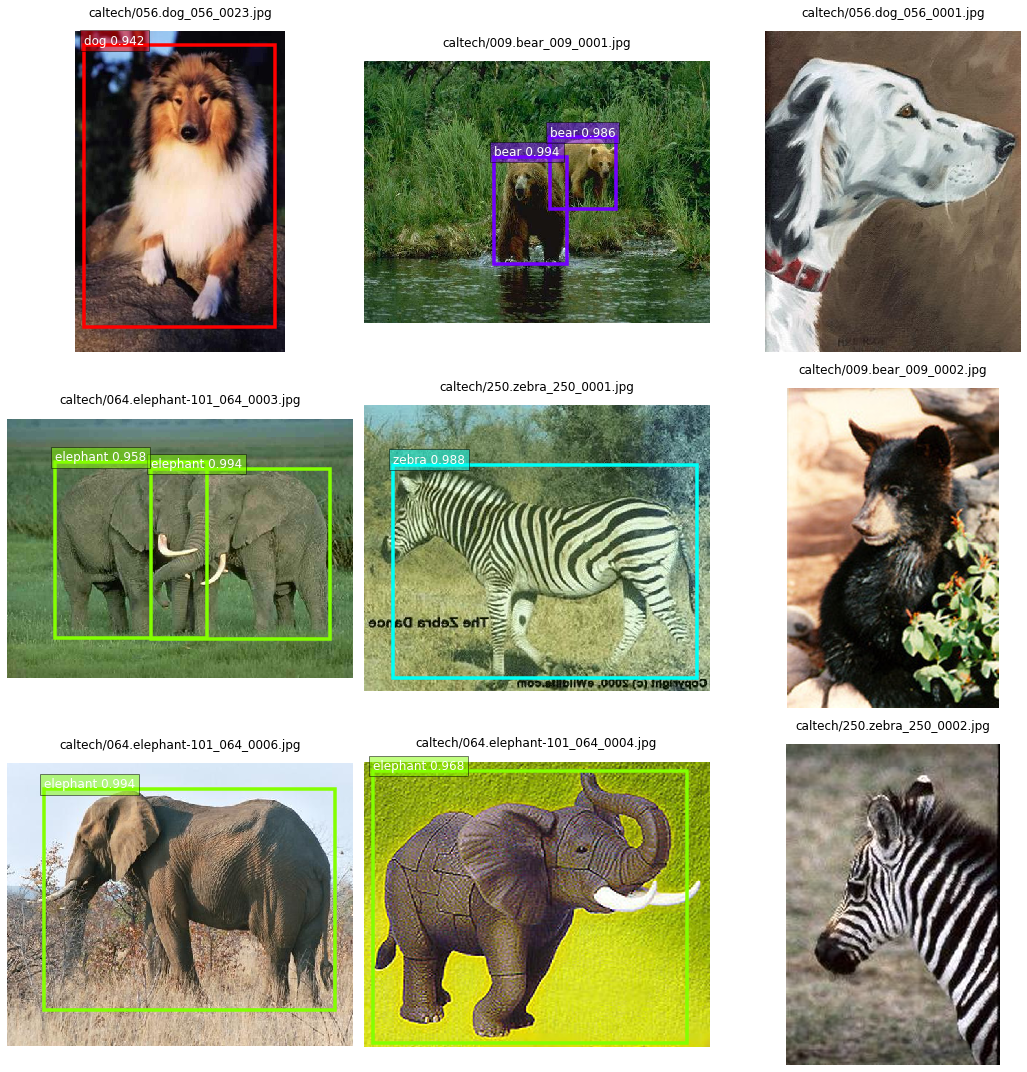

In [18]:
#cell 18
n_pics = len(test_images)
n_cols = 3
n_rows = max(math.ceil(n_pics / n_cols), 2)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
[ax.axis("off") for ax_dim in axes for ax in ax_dim]
for i, pic in enumerate(test_images):
    curr_col = i % n_cols
    curr_row = i // n_cols
    # download and pre-process image
    print(pic)
    im_array = image.imread(pic)
    x, orig_img = data.transforms.presets.yolo.transform_test(im_array)
    # forward pass and display
    box_ids, scores, bboxes = net(x)
    ax = utils.viz.plot_bbox(
        orig_img,
        bboxes[0],
        scores[0],
        box_ids[0],
        class_names=classes,
        thresh=0.9,
        ax=axes[curr_row, curr_col],
    )
    ax.axis("off")
    ax.set_title(pic, pad=15)
fig.tight_layout()
fig.show();

## Deploy the detection server
 1. We first need to **send the model to S3**, as we will provide the S3 model path to Amazon SageMaker endpoint creation API
 1. We create a **serving script** containing model deserialization code and inference logic. This logic is in the `repo` folder.
 1. We **deploy the endpoint** with a SageMaker SDK call

### Save local model, compress and send to S3

Clarify needs a model since it will spin up its own inference endpoint to get explanations. We will now export the local model, archieve it and then create a **SageMaker model** from this archieve which allows to create other resources that depend on this model.

In [19]:
#cell 19
# save the full local model (both weights and graph)
net.export(MODEL_NAME, epoch=0)

In [20]:
#cell 20
# compress into a tar file
model_file = "model.tar.gz"
tar = tarfile.open(model_file, "w:gz")
tar.add("{}-symbol.json".format(MODEL_NAME))
tar.add("{}-0000.params".format(MODEL_NAME))
tar.close()

In [21]:
#cell 21
# upload to s3
model_data_s3_uri = sm_sess.upload_data(model_file, key_prefix=S3_KEY_PREFIX)
model_data_s3_uri

's3://sagemaker-us-east-1-377661786567/clarify_object_detection/model.tar.gz'

## Instantiate model

We use batching of images on the predictor entry_point in order to achieve higher performance as utilization of resources is better than one image at a time.

In [22]:
#cell 22
model = MXNetModel(
    model_data=model_data_s3_uri,
    role=sm_role,
    py_version="py37",
    entry_point="detection_server_batch.py",
    source_dir="repo",
    framework_version="1.8.0",
    sagemaker_session=sm_sess,
)

container_def = model.prepare_container_def(instance_type=ENDPOINT_INSTANCE_TYPE)
model_name = gen_unique_name(MODEL_NAME)
sm_sess.create_model(role=sm_role, name=model_name, container_defs=[container_def])

Using already existing model: yolo3-darknet53-coco-72474288


'yolo3-darknet53-coco-72474288'

## (Optional) Create endpoint and get predictions, model IO in depth

In this optional section we deploy an endpoint to get predictions and dive deep into details that can be helpful to troubleshot issues related to expected model IO format of predictions, serialization and tensor shapes. 

Common pitfalls are usually solved by making sure we are using the right serializer and deserializer and that the model output conforms to the expectations of Clarify in terms of shapes and semantics of the output tensors.

In general, Clarify expectes that our model receieves a batch of images and outputs a batch of image detections with a tensor having the following elements: **class id, prediction score and normalized bounding box of the detection.**

In [23]:
#cell 23
endpoint_name = gen_unique_name(MODEL_NAME)
endpoint_name

'yolo3-darknet53-coco-72474288'

Delete any previous enpoint

In [24]:
#cell 24
try:
    sm_sess.delete_endpoint(endpoint_name)
except:
    pass

Delete any stale endpoint config

In [25]:
#cell 25
try:
    sm_sess.delete_endpoint_config(endpoint_name)
except botocore.exceptions.ClientError as e:
    print(e)
    pass

Deploy the model in a SageMaker endpoint

In [26]:
#cell 26
import sagemaker.serializers
import sagemaker.deserializers

print(model.name)
predictor = model.deploy(
    initial_instance_count=1,
    instance_type=ENDPOINT_INSTANCE_TYPE,
    endpoint_name=endpoint_name,
    serializer=sagemaker.serializers.NumpySerializer(),
    deserializer=sagemaker.deserializers.JSONDeserializer(),
)

None
-------!

In [27]:
#cell 27
predictor.deserializer

In [28]:
#cell 28
predictor.serializer

In [29]:
#cell 29
predictor.accept

('application/json',)

Let's go in detail on how the detection server works, let's take the following test image as an example:

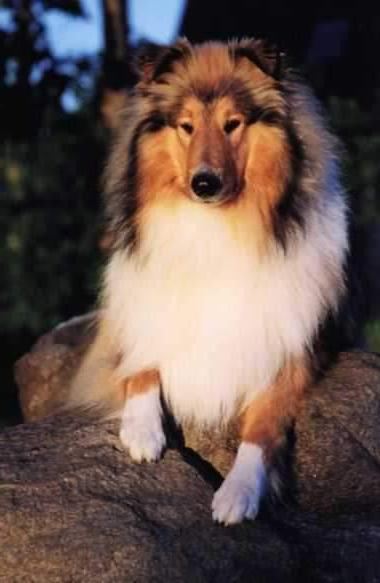

In [30]:
#cell 30
im = Image.open(test_images[0])
im

Since we overrode the `transform_fn` making it support batches and normalizing the detection boxes, we feed a tensor with a single batch, H, W and the 3 color channels as input

In [31]:
#cell 31
im_np = np.array([np.asarray(im)])

In [32]:
#cell 32
im_np.shape

(1, 583, 380, 3)

In [33]:
#cell 33
(H, W) = im_np.shape[1:3]

In [34]:
#cell 34
(H, W)

(583, 380)

Send the image to the predictor and get detections

In [35]:
#cell 35
tensor = np.array(predictor.predict(im_np))

In [36]:
#cell 36
tensor

array([[[0.        , 0.932432  , 0.0356288 , 0.03814635, 0.95637333,
         0.9229455 ]]])

In [37]:
#cell 37
tensor.shape

(1, 1, 6)

Our prediction has one batch, 3 detections and 6 elements containing class_id, score and normalized box with upper left corner, and lower left corner.

In [38]:
#cell 38
box_scale = np.array([W, H, W, H])

To display the detections we undo the normalization and split the detection format that clarify uses so we use the gluon plot_bbox function with the non-normalized boxes and separate scores and class ids from detections

In [39]:
#cell 39
box_scale

array([380, 583, 380, 583])

In [40]:
#cell 40
numdet = tensor.shape[1]
cids = np.zeros(numdet)
scores = np.zeros(numdet)
bboxes = np.zeros((numdet, 4))
for i, det in enumerate(tensor[0]):
    cids[i] = det[0]
    scores[i] = det[1]
    bboxes[i] = det[2:]
    bboxes[i] *= box_scale
    bboxes[i] = bboxes[i].astype("int")

In [41]:
#cell 41
bboxes

array([[ 13.,  22., 363., 538.]])

In [42]:
#cell 42
scores

array([0.932432])

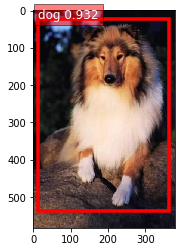

In [43]:
#cell 43
utils.viz.plot_bbox(np.asarray(im), bboxes, scores, cids, class_names=classes, thresh=0.8)

We can group the logic above in a function to make it more convenient to use

In [44]:
#cell 44
def detect(pic, predictor):
    """elementary function to send a picture to a predictor"""
    im = Image.open(pic)
    im = im.convert("RGB")
    im_np = np.array([np.asarray(im)])
    (h, w) = im_np.shape[1:3]
    prediction = np.array(predictor.predict(im_np))
    box_scale = np.array([w, h, w, h])
    numdet = prediction.shape[1]
    cids = np.zeros(numdet)
    scores = np.zeros(numdet)
    bboxes = np.zeros((numdet, 4))
    for i, det in enumerate(prediction[0]):
        cids[i] = det[0]
        scores[i] = det[1]
        bboxes[i] = det[2:]
        bboxes[i] *= box_scale
        bboxes[i] = bboxes[i].astype("int")
    return (cids, scores, bboxes)

In [48]:
#cell 45
pic = test_images[0]
cids, scores, bboxes = detect(pic, predictor)

In [49]:
#cell 46
cids

array([0.])

In [50]:
#cell 47
bboxes

array([[ 13.,  22., 363., 538.]])

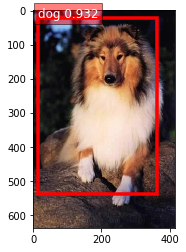

In [51]:
#cell 48
#for local viz we need to resize local pic to the server-side resize
_, orig_img = data.transforms.presets.yolo.load_test(pic)
utils.viz.plot_bbox(orig_img, bboxes, scores, cids, class_names=classes, thresh=0.9)

In [52]:
#cell 49
cids

array([0.])

There's a single detection of a dog which is class index 0 as in the beginning of the notebook where we called `reset_class`

# Amazon Sagemaker Clarify

We will now showcase how to use SageMaker Clarify to explain detections by the model, for that we have already done some work in `detection_server_batch.py` to filter out missing detections with index `-1` and we have normalized the boxes to the image dimensions. We only need to upload the data to s3, provide the configuration for Clarify in the `analysis_config.json` describing the explainability job parameters and execute the processing job with the data and configuration as inputs. As a result, we will get in S3 the explanation for the detections of the model.

Clarify expects detections to be in the format explored in the cells above. Detections should come in a tensor of shape `(num_images, batch, detections, 6)`. The first number of each detection is the predicted class label. The second number is the associated confidence score for the detection. The last four numbers represent the bounding box coordinates `[xmin / w, ymin / h, xmax / w, ymax / h]`. These output bounding box corner indices are normalized by the overall image size dimensions, where `w` is the width of the image, and `h` is the height.

#### Upload some test images to get explanations

In [53]:
#cell 49
s3_test_images = f"{S3_KEY_PREFIX}/test_images"

In [54]:
#cell 50
!mkdir -p test_images
!cp {TEST_IMAGE_DIR}/009.bear_009_0002.jpg test_images
!cp {TEST_IMAGE_DIR}/064.elephant-101_064_0003.jpg test_images

In [55]:
#cell 51
dataset_uri = sm_sess.upload_data("test_images", key_prefix=s3_test_images)
dataset_uri

's3://sagemaker-us-east-1-377661786567/clarify_object_detection/test_images'

We use this noise image as a baseline to mask different segments of the image during the explainability process

In [56]:
#cell 52
baseline_uri = sm_sess.upload_data("noise_rgb.png", key_prefix=S3_KEY_PREFIX)

It's very important that `predictor.content_type` and `predictor.accept_type` in the json fields below match the sagemaker python sdk `predictor.serializer` and `predictor.deserializer` class instances above such as `sagemaker.serializers.NumpySerializer` so Clarify job can use the right (de)serializer.

### Clarify job configuration for object detection type of models
We will configure important parameters of the Clarify job for object detection under `image_config`:

 * **num_samples**: This number determines the size of the generated synthetic dataset to compute the SHAP values. More samples will produce more accurate explanations but will consume more computational resources
 * **baseline**: image that will be used to mask segments during Kernel SHAP
 * **num_segments**: number of segments to partition the detection image into 
 * **max_objects**: maximum number of objects starting from the first that will be considered sorted by predicted score
 * **iou_threshold**: minimum IOU for considering predictions against the original detections, as detection boxes will shift during masking
 * **context**: whether to mask the image background when running SHAP, takes values 0 or 1


<hr/>

Below we use the [Sagemaker Python SDK](https://sagemaker.readthedocs.io/en/stable/api/training/processing.html?highlight=clarify#module-sagemaker.clarify) which helps create an [Analysis configuration](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-configure-processing-jobs.html) but using higher level Python classes.


In [57]:
#cell 53
from sagemaker.clarify import (
    SageMakerClarifyProcessor,
    ModelConfig,
    DataConfig,
    SHAPConfig,
    ImageConfig,
    ModelPredictedLabelConfig,
)
from sagemaker.utils import unique_name_from_base

Configure parameters of the Clarify Processing job. The job has one input, the config file and one output, the resulting analysis of the model.

In [58]:
#cell 54
analyzer_instance_count = 1
analyzer_instance_type = "ml.c5.xlarge"
output_bucket = sm_sess.default_bucket()
# Here we specify where to store the results.
analysis_result_path = "s3://{}/{}/{}".format(output_bucket, S3_KEY_PREFIX, "cv_analysis_result")

clarify_processor: SageMakerClarifyProcessor = SageMakerClarifyProcessor(
    role=sm_role,
    instance_count=analyzer_instance_count,
    instance_type=analyzer_instance_type,
    max_runtime_in_seconds=3600,
    sagemaker_session=sm_sess,
)

model_config: ModelConfig = ModelConfig(
    model_name=model_name,
    instance_count=1,
    instance_type=ENDPOINT_INSTANCE_TYPE,
    content_type="application/x-npy",
)


data_config: DataConfig = DataConfig(
    s3_data_input_path=dataset_uri,
    s3_output_path=analysis_result_path,
    dataset_type="application/x-image",
)

image_config: ImageConfig = ImageConfig(
    model_type="OBJECT_DETECTION",
    feature_extraction_method="segmentation",
    num_segments=20,
    segment_compactness=5,
    max_objects=5,
    iou_threshold=0.5,
    context=1.0,
)

shap_config: SHAPConfig = SHAPConfig(
    baseline=baseline_uri,
    num_samples=500,
    image_config=image_config,
)


predictions_config = ModelPredictedLabelConfig(probability_threshold=0.8, label_headers=net.classes)

DataConfig will be deprecated on 15 Mar 2022.s3_data_distribution_type parameter will no longer be supported. Everything else will remain as is in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Now run the processing job, it will take approximately 6 minutes.

In [59]:
#cell 55
clarify_processor.run_explainability(
    data_config=data_config,
    model_config=model_config,
    model_scores=predictions_config,
    explainability_config=shap_config,
    job_name=unique_name_from_base("clarify-cv-object-detection"),
    wait=True,
)


Job Name:  clarify-cv-object-detection-1646409346-0a20
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-377661786567/clarify_object_detection/test_images', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-377661786567/clarify_object_detection/cv_analysis_result/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-377661786567/clarify_object_detection/cv_analysis_result', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
...................

We download the results of the Clarify job and inspect the attributions

In [60]:
#cell 56
!aws s3 cp --recursive {analysis_result_path} cv_analysis_result

download: s3://sagemaker-us-east-1-377661786567/clarify_object_detection/cv_analysis_result/analysis_config.json to cv_analysis_result/analysis_config.json
download: s3://sagemaker-us-east-1-377661786567/clarify_object_detection/cv_analysis_result/064.elephant-101_064_0003_objects.jpeg to cv_analysis_result/064.elephant-101_064_0003_objects.jpeg
download: s3://sagemaker-us-east-1-377661786567/clarify_object_detection/cv_analysis_result/report.pdf to cv_analysis_result/report.pdf
download: s3://sagemaker-us-east-1-377661786567/clarify_object_detection/cv_analysis_result/009.bear_009_0002_objects.jpeg to cv_analysis_result/009.bear_009_0002_objects.jpeg
download: s3://sagemaker-us-east-1-377661786567/clarify_object_detection/cv_analysis_result/shap_064.elephant-101_064_0003_box1.jpeg to cv_analysis_result/shap_064.elephant-101_064_0003_box1.jpeg
download: s3://sagemaker-us-east-1-377661786567/clarify_object_detection/cv_analysis_result/shap_064.elephant-101_064_0003_box2.jpeg to cv_analy

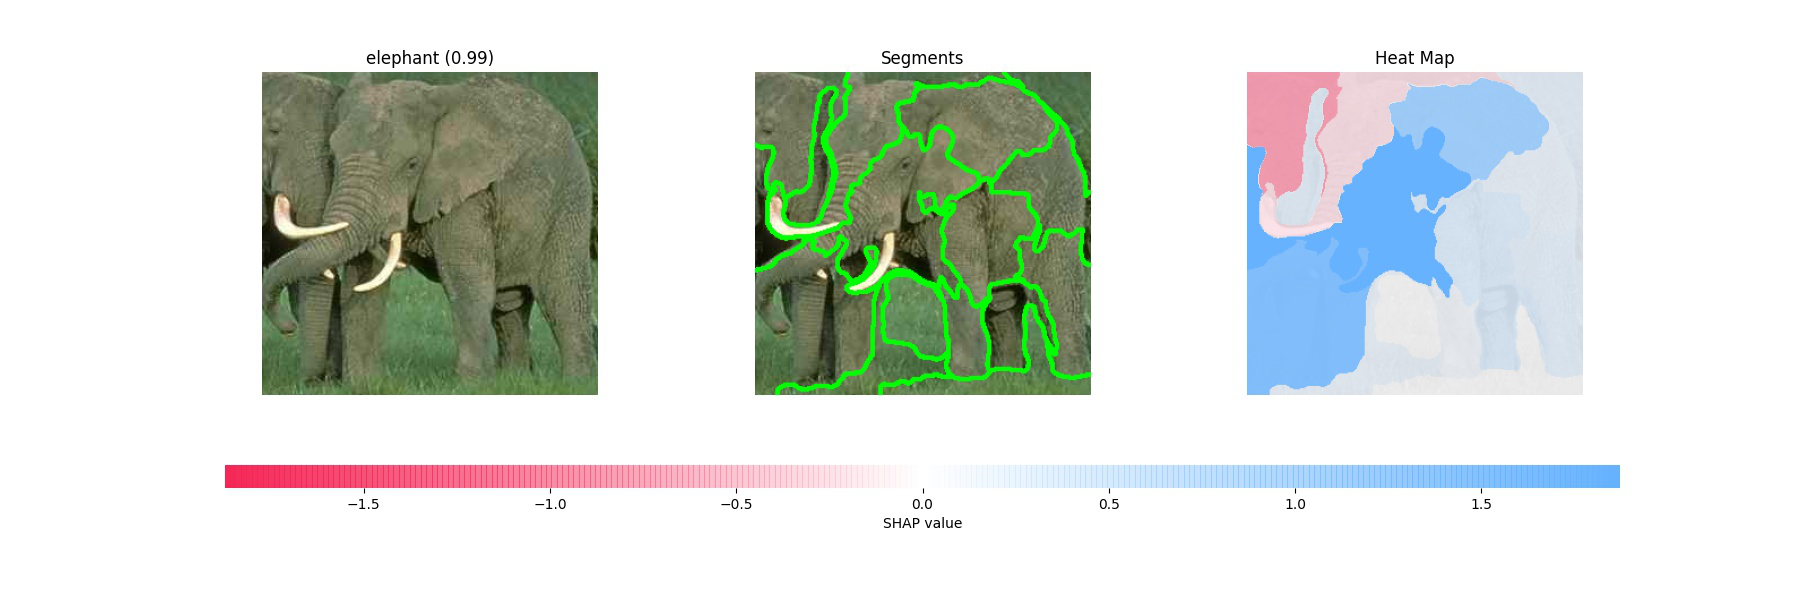

In [61]:
#cell 57
im = Image.open("cv_analysis_result/shap_064.elephant-101_064_0003_box1.jpeg")
im

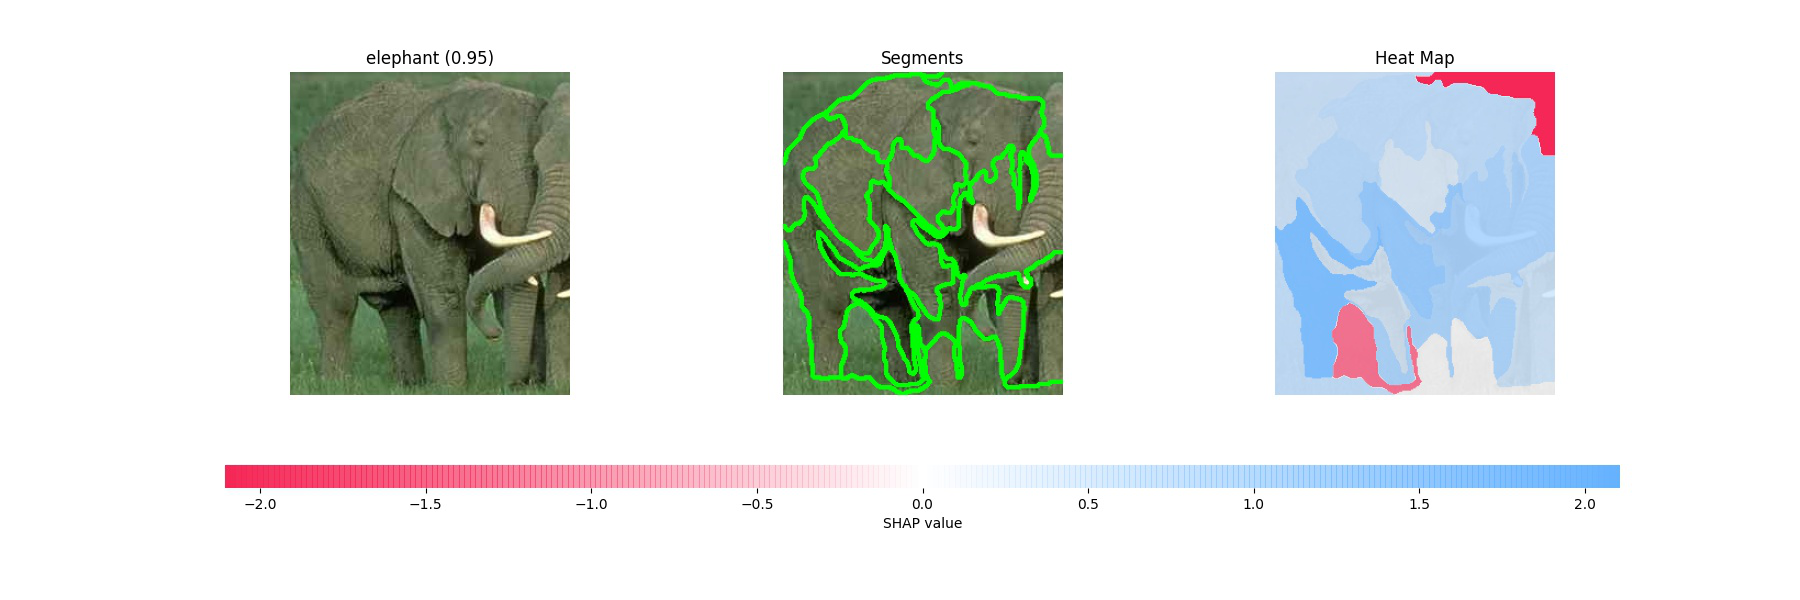

In [62]:
#cell 58
im = Image.open("cv_analysis_result/shap_064.elephant-101_064_0003_box2.jpeg")
im

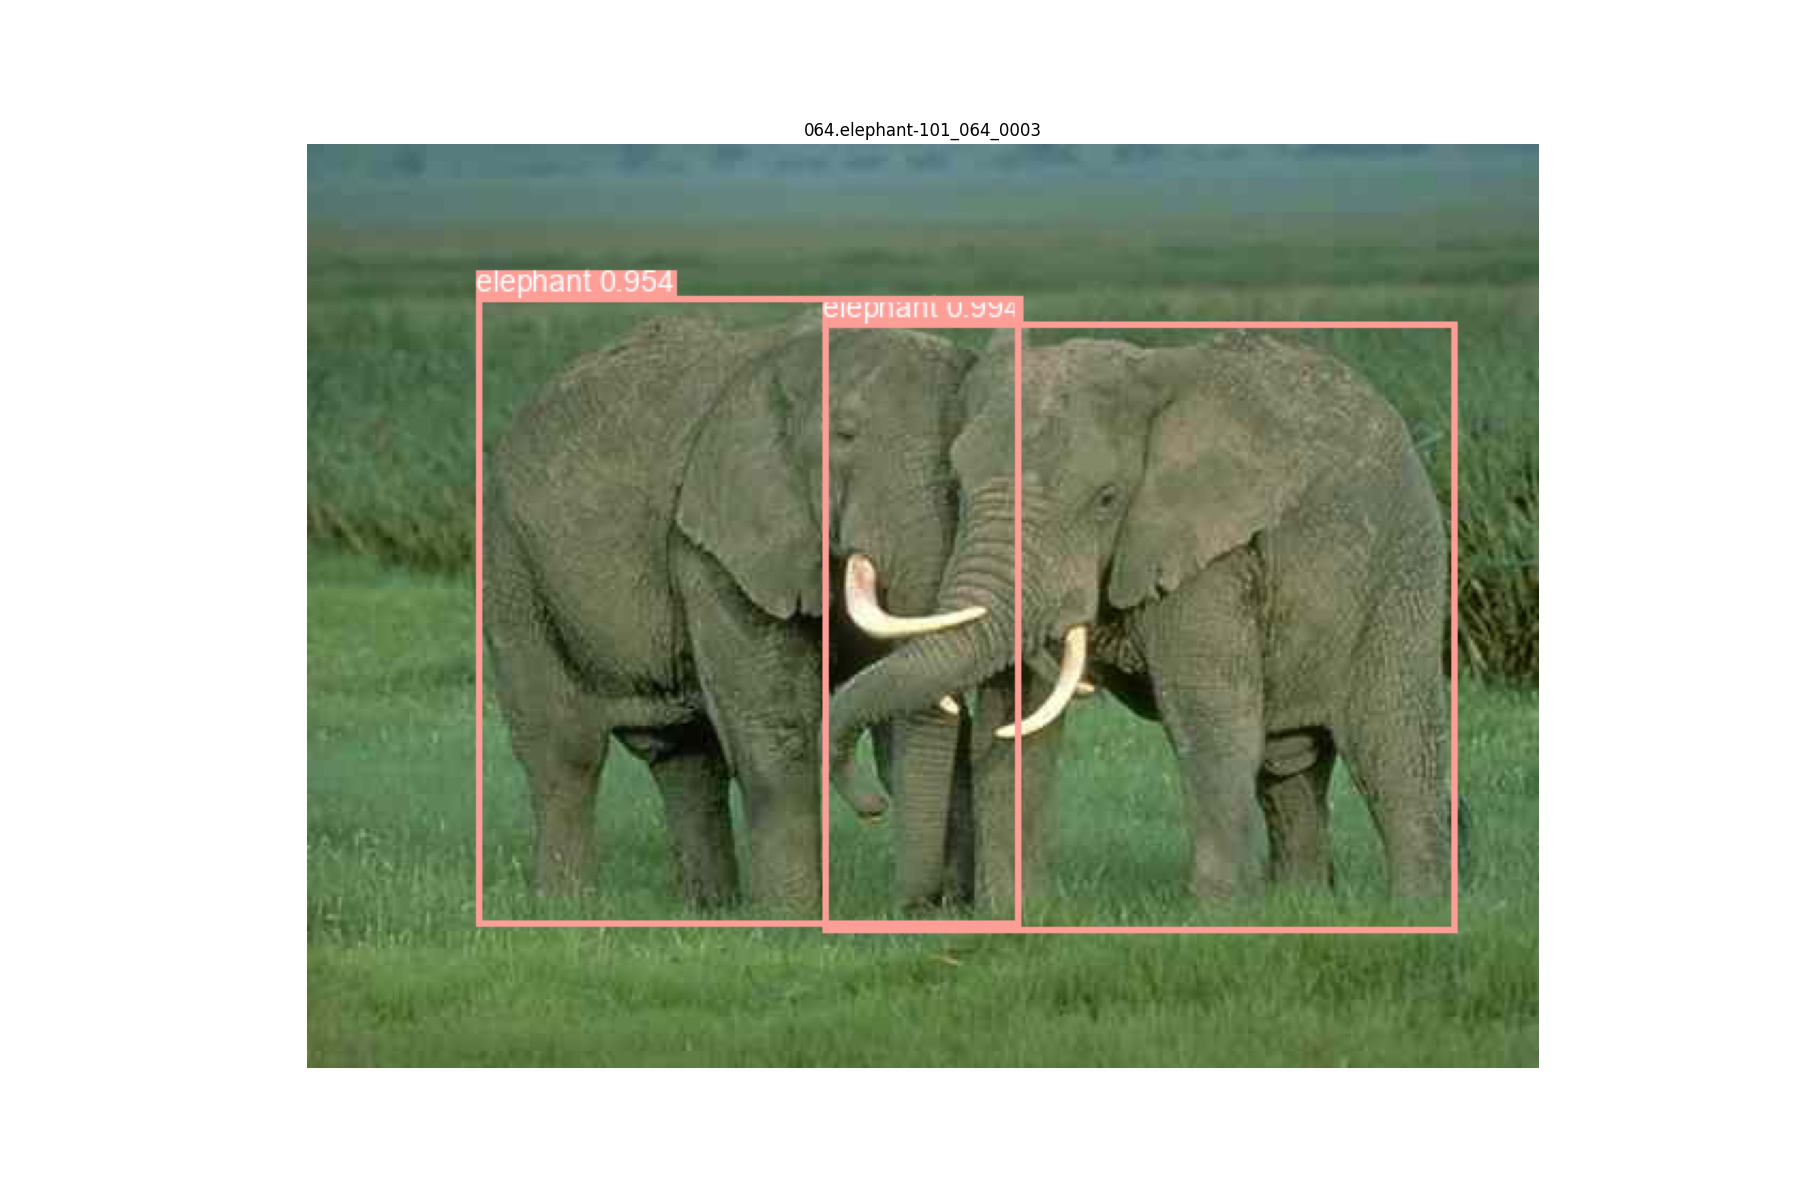

In [63]:
#cell 59
im = Image.open("cv_analysis_result/064.elephant-101_064_0003_objects.jpeg")
im

### Cleanup of resources

We delete the previous endpoint

In [ ]:
#cell 60
sm_sess.delete_endpoint(endpoint_name)